### Mncedisi Mncwabe - ayoba Senior Data Scientist Assessment

#### To do if need to test the code functionality and that it produces results as expected:
- Update csv file paths to train and test data in the read_data function
- Update the path of the BigQuery service account json file to authenticate to the relevant BigQuery project when calling the load_to_bigquery function. (I used a personal BQ account for this assessment)

In [83]:
# for analysis and data processing
import pandas as pd
import numpy as np
import seaborn as sns
import ppscore as pps
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
# for modelling
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,precision_recall_curve,f1_score
from sklearn.metrics import confusion_matrix, precision_score,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import shap
# for BigQuery authentication
from google.oauth2.service_account import Credentials
from oauth2client.service_account import ServiceAccountCredentials

In [19]:
def read_data(path_to_csv_file):
    '''
    Reads csv files from specified paths

    Parameters:
            path to csv file locations
    Returns:
            dataframes of imported csv files
    '''
    # Read CSV files
    df = pd.read_csv(path_to_csv_file)
    
    return df

# call the function to import train data - update with relevant paths
has_uninstalled_train = read_data('.../Simfy_Technical_Assessment_2024/train/has_uninstalled_train.csv')
message_received_train = read_data('.../Simfy_Technical_Assessment_2024/train/message_received_train.csv')
message_sent_train = read_data('.../Simfy_Technical_Assessment_2024/train/message_sent_train.csv')
music_played_train = read_data('.../Simfy_Technical_Assessment_2024/train/music_played_train.csv')

# import test data
has_uninstalled_test = read_data('.../Simfy_Technical_Assessment_2024/test/has_uninstalled_test.csv')
message_received_test = read_data('.../Simfy_Technical_Assessment_2024/test/message_received_test.csv')
message_sent_test = read_data('.../Simfy_Technical_Assessment_2024/test/message_sent_test.csv')
music_played_test = read_data('.../Simfy_Technical_Assessment_2024/test/music_played_test.csv')

In [4]:
def df_snapshot(df):
    '''
    Returns top 5 rows of the dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return display(df.head())

print(f'has_uninstalled_train:')
df_snapshot(has_uninstalled_train)
print(f'message_received_train:')
df_snapshot(message_received_train)
print(f'message_sent_train:')
df_snapshot(message_sent_train)
print(f'music_played_train:')
df_snapshot(music_played_train)

has_uninstalled_train:


,id,has_uninstalled
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,1.0


message_received_train:


,id,event_timestamp
0,0,2021-05-31 09:22:50
1,0,2021-05-23 00:45:59
2,0,2021-05-02 01:33:14
3,0,2021-05-01 17:31:03
4,0,2021-05-23 10:16:34


message_sent_train:


,id,event_timestamp
0,0,2021-05-01 06:41:46
1,0,2021-05-04 21:34:48
2,0,2021-05-30 08:03:28
3,0,2021-05-29 14:33:51
4,0,2021-05-07 03:40:03


music_played_train:


,id,event_timestamp,minutes
0,0,2021-05-09 13:11:28,18
1,0,2021-05-05 03:10:45,16
2,0,2021-05-29 10:37:23,14
3,0,2021-05-07 04:43:08,11
4,0,2021-05-10 03:43:45,15


In [5]:
def data_types(df):
    '''
    Returns datatype of fields in a dataframe.

    Parameters:
        df (DataFrame): Pandas dataframe
    '''
    return df.info()

print(f'has_uninstalled_train:')
data_types(has_uninstalled_train)
print(f'message_received_train:')
data_types(message_received_train)
print(f'message_sent_train:')
data_types(message_sent_train)
print(f'music_played_train:')
data_types(music_played_train)

has_uninstalled_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5000 non-null   int64  
 1   has_uninstalled  5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB
message_received_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652828 entries, 0 to 652827
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               652828 non-null  int64 
 1   event_timestamp  652828 non-null  object
dtypes: int64(1), object(1)
memory usage: 10.0+ MB
message_sent_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592815 entries, 0 to 592814
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               592815 non-null  int64 

In [20]:
def convert_event_time_to_datetime(df,column):
    """
    Returns a dataframe with converted event_timestamp field from object to datetime
    
    Parameters:
        df (DataFrame): Pandas dataframe
        column (Object): Object field to datetime
    
    """
    df[column] = pd.to_datetime(df[column])
    
    return df

# convert in train
convert_event_time_to_datetime(message_received_train,'event_timestamp')
convert_event_time_to_datetime(message_sent_train,'event_timestamp')
convert_event_time_to_datetime(music_played_train,'event_timestamp')

# convert in test
convert_event_time_to_datetime(message_received_test,'event_timestamp')
convert_event_time_to_datetime(message_sent_test,'event_timestamp')
convert_event_time_to_datetime(music_played_test,'event_timestamp')

,id,event_timestamp,minutes
0,5000,2021-05-03 11:35:59,18
1,5000,2021-05-21 10:15:53,12
2,5000,2021-05-29 21:07:33,17
3,5000,2021-05-23 15:33:44,9
4,5000,2021-05-04 21:03:11,16
...,...,...,...
8365,5999,2021-05-16 17:24:43,16
8366,5999,2021-05-09 16:37:17,16
8367,5999,2021-05-29 14:20:15,20
8368,5999,2021-05-02 21:46:57,12


In [25]:
def convert_has_uninstalled_to_int(df,column):
    """
    Returns a dataframe with converted has_uninstalled field float to int data type
    
    Parameters:
        df (DataFrame): Pandas dataframe
        column (Float): Float to int
    
    """
    df[column] = df[column].astype(int)
    
    return df

# convert in train
convert_has_uninstalled_to_int(has_uninstalled_train,'has_uninstalled')

,id,has_uninstalled
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
4995,4995,0
4996,4996,1
4997,4997,0
4998,4998,1


In [21]:
def null_checker(df):
    '''
    Returns the count of rows found in the data frame where there is a null present.

    Parameters:
        df (Dataframe): Pandas dataframe

    Returns:
        Prints the null count, null percentage, and row count per column.
    '''
    row_count = len(df)
    null_counts = df.isnull().sum().sort_values(ascending=False)
    null_percentages = (null_counts / row_count) * 100
    combined = pd.concat([null_counts, null_percentages], axis=1, keys=['Null Count', 'Null Percentage'])
    combined['Row Count'] = row_count
    print(combined)

# check nulls in train
print(f'has_uninstalled_train:')
null_checker(has_uninstalled_train)
print(f'message_received_train:')
null_checker(message_received_train)
print(f'message_sent_train:')
null_checker(message_sent_train)
print(f'music_played_train:')
null_checker(music_played_train)

# check nulls in test
print(f'has_uninstalled_test:')
null_checker(has_uninstalled_test)
print(f'message_received_test:')
null_checker(message_received_test)
print(f'message_sent_test:')
null_checker(message_sent_test)
print(f'music_played_test:')
null_checker(music_played_test)

has_uninstalled_train:
                 Null Count  Null Percentage  Row Count
id                        0              0.0       5000
has_uninstalled           0              0.0       5000
message_received_train:
                 Null Count  Null Percentage  Row Count
id                        0              0.0     652828
event_timestamp           0              0.0     652828
message_sent_train:
                 Null Count  Null Percentage  Row Count
id                        0              0.0     592815
event_timestamp           0              0.0     592815
music_played_train:
                 Null Count  Null Percentage  Row Count
id                        0              0.0      42512
event_timestamp           0              0.0      42512
minutes                   0              0.0      42512
has_uninstalled_test:
    Null Count  Null Percentage  Row Count
id           0              0.0       1000
message_received_test:
                 Null Count  Null Percentage  Row Coun

In [15]:
def load_to_bigquery(df, df_name, bq_project_id, bq_dataset_id, google_service_account_file):
    '''
    Loads the train data to a Google BigQuey (BQ) table.
    
    Parameters:
        df (DataFrame): Pandas dataframe to load.
        df_name (str): Name of the dataframe, which will be used as the BQ table name/id.
        bq_project_id (str): BQ project id.
        bq_dataset_id (str): BQ dataset id.
        google_service_account_file (credentials): Google service account to authenticate read/write access to a BQ table.
    '''
    
    destination_table = f"{bq_project_id}.{bq_dataset_id}.{df_name}"
    df.to_gbq(destination_table=destination_table,
              project_id=bq_project_id,
              credentials=google_service_account_file,
              chunksize=10000,
              progress_bar=False,
              if_exists='replace')

    

# BigQuery authentication - update with relevant credentials path and project/dataset id
bq_project_id = 'bright-arc-328707'
bq_dataset_id = 'ayoba'
credentials_path = '.../bright-arc-328707-b5e2d782b48b.json'
google_service_account_file = Credentials.from_service_account_file(credentials_path)

# Call the function
load_to_bigquery(has_uninstalled_train, 'has_uninstalled_train', bq_project_id, bq_dataset_id, google_service_account_file)
load_to_bigquery(message_received_train, 'message_received_train', bq_project_id, bq_dataset_id, google_service_account_file)
load_to_bigquery(message_sent_train, 'message_sent_train', bq_project_id, bq_dataset_id, google_service_account_file)
load_to_bigquery(music_played_train, 'music_played_train', bq_project_id, bq_dataset_id, google_service_account_file)

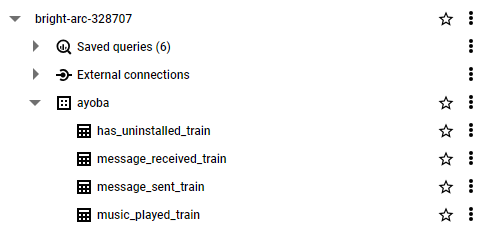

## 1.3 Data modeling and analysis

### 1.3.1 Analysis

In [77]:
def create_user_features(message_sent_train, message_received_train, music_played_train, has_uninstalled_train=None):
    """
    Creates user features for analysis.

    Parameters:
        message_sent_train (DataFrame): DataFrame with messages sent records.
        message_received_train (DataFrame): DataFrame with messages received records.
        music_played_train (DataFrame): DataFrame with music played records.
        has_uninstalled_train (DataFrame): DataFrame with user churn data.

    Returns:
        DataFrame: A merged DataFrame with user features and churn status.
    """
    # Messages sent and received count
    msg_sent_count = message_sent_train.groupby('id').size().reset_index(name='messages_sent_count')
    msg_received_count = message_received_train.groupby('id').size().reset_index(name='messages_received_count')

    total_minutes = music_played_train.groupby('id')['minutes'].sum().reset_index(name='total_minutes_played')
    average_minutes = music_played_train.groupby('id')['minutes'].mean().reset_index(name='average_minutes_per_session')
    
    if has_uninstalled_train is not None:
        base_df = has_uninstalled_train
    else:
        ids = set(message_sent_train['id']).union(set(message_received_train['id']), set(music_played_train['id']))
        base_df = pd.DataFrame(list(ids), columns=['id'])

    user_features = base_df.merge(msg_sent_count, on='id', how='left').merge(
        msg_received_count, on='id', how='left').merge(
        total_minutes, on='id', how='left').merge(
        average_minutes, on='id', how='left')

    # Fill NaN values (for users with no records in certain activities) with 0
    user_features.fillna(0, inplace=True)

    return user_features

user_features_train = create_user_features(message_sent_train, message_received_train, music_played_train, has_uninstalled_train)
user_features_test = create_user_features(message_sent_test, message_received_test, music_played_test)
user_features_train.head()

,id,has_uninstalled,messages_sent_count,messages_received_count,total_minutes_played,average_minutes_per_session
0,0,0,196.0,183.0,104.0,9.454545
1,1,0,214.0,202.0,112.0,12.444444
2,2,0,235.0,118.0,83.0,9.222222
3,3,0,181.0,218.0,114.0,10.363636
4,4,1,43.0,65.0,127.0,12.700000


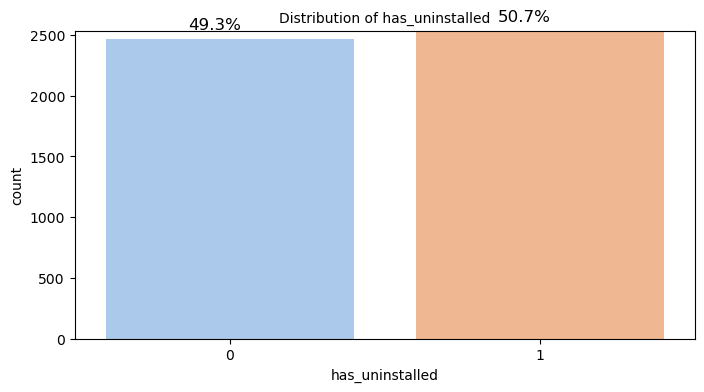

In [78]:
# plot distribution of has_uninstalled to check if there's class imbalance or not
plt.figure(figsize=(8, 4))
plt.title("Distribution of has_uninstalled", fontsize=10)
plot = sns.countplot(x='has_uninstalled', data=user_features_train, palette='pastel')
plt.ylim(0, user_features_train['has_uninstalled'].value_counts().max() + 1)  

def target(plot):
    total = len(user_features_train['has_uninstalled'])
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size=12, ha='center', va='center', xytext=(0, 10), textcoords='offset points')

target(plot)
plt.show()

- The two classes for has_uninstalled almost have the same distribution (49.3% of users who did not remove the app and 50.7% users who have removed the app), indicating no class imbalance exists

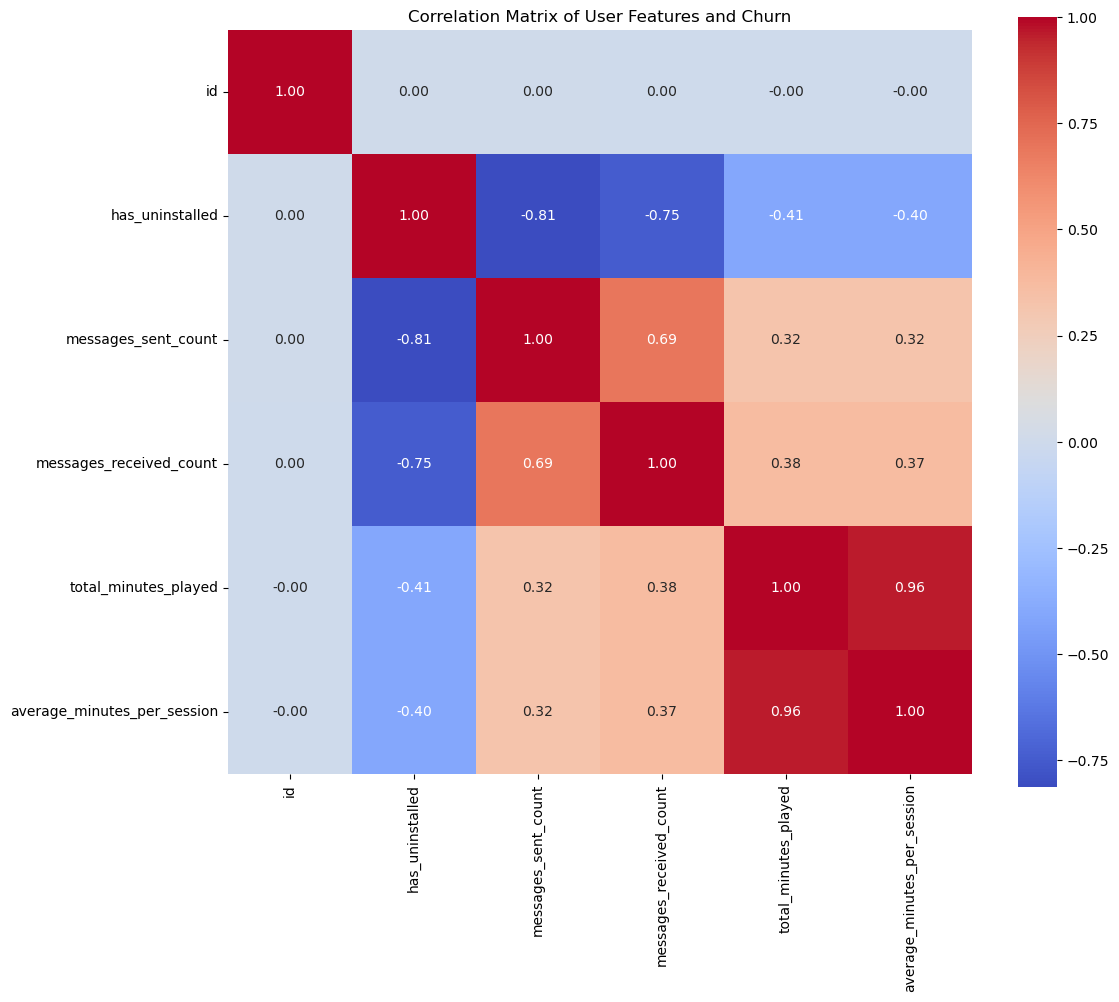

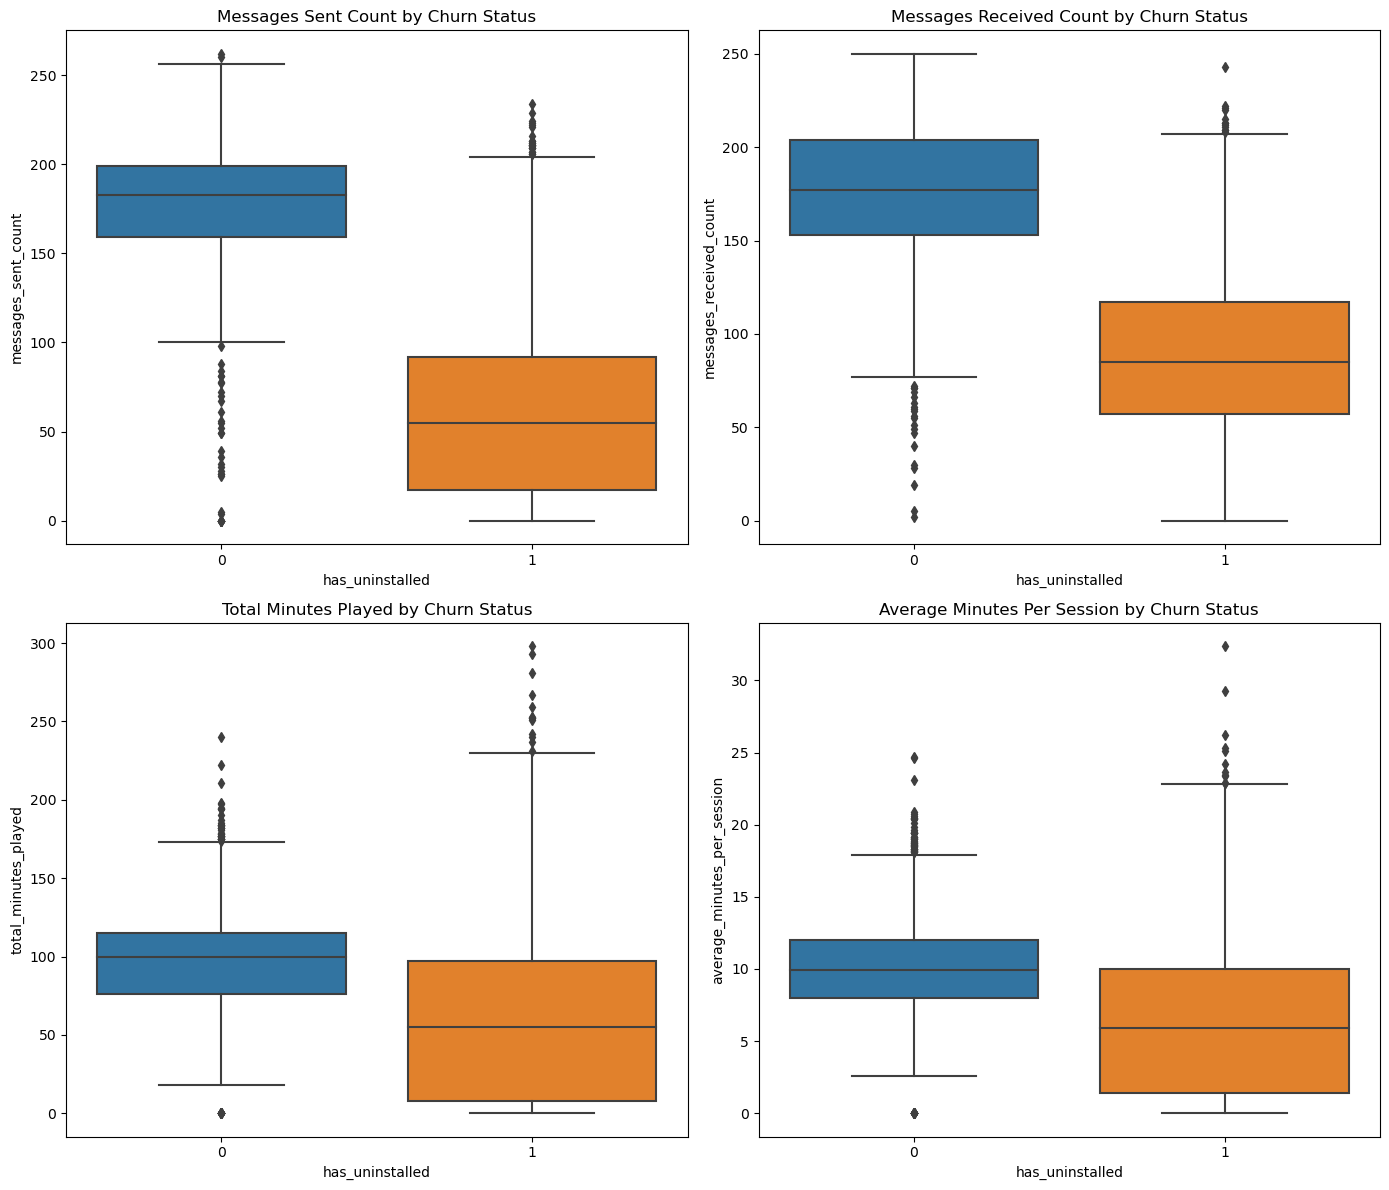

In [79]:
def plot_user_data(user_features_train):
    """
    Plots correlation matrix and boxplots for user features including churn status.

    Parameters:
        user_features (DataFrame): Pandas DataFrame containing user features.

    Returns:
        Displays a heatmap of the correlation matrix and boxplots for user features by churn status.
    """
    plt.figure(figsize=(12, 10))
    corr = user_features_train.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title('Correlation Matrix of User Features and Churn')
    plt.show()

    fig, ax = plt.subplots(2, 2, figsize=(14, 12))

    sns.boxplot(x='has_uninstalled', y='messages_sent_count', data=user_features_train, ax=ax[0, 0])
    ax[0, 0].set_title('Messages Sent Count by Churn Status')

    sns.boxplot(x='has_uninstalled', y='messages_received_count', data=user_features_train, ax=ax[0, 1])
    ax[0, 1].set_title('Messages Received Count by Churn Status')

    sns.boxplot(x='has_uninstalled', y='total_minutes_played', data=user_features_train, ax=ax[1, 0])
    ax[1, 0].set_title('Total Minutes Played by Churn Status')
    
    sns.boxplot(x='has_uninstalled', y='average_minutes_per_session', data=user_features_train, ax=ax[1, 1])
    ax[1, 1].set_title('Average Minutes Per Session by Churn Status')

    plt.tight_layout()
    plt.show()

plot_user_data(user_features_train)

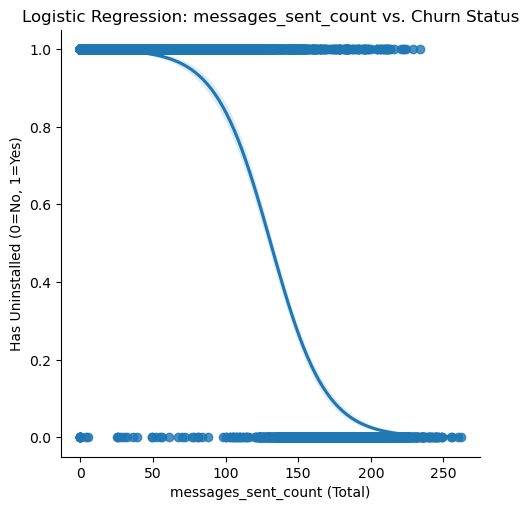

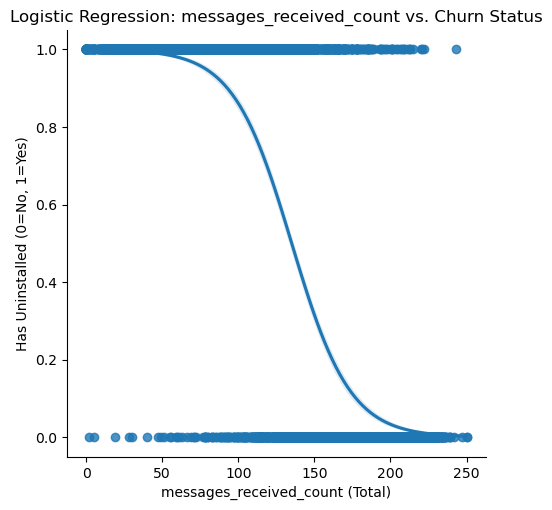

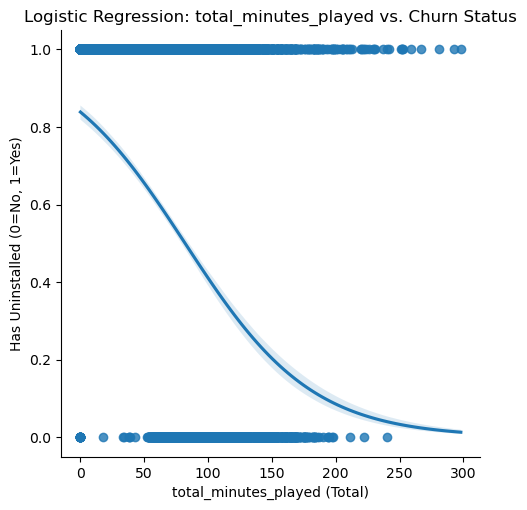

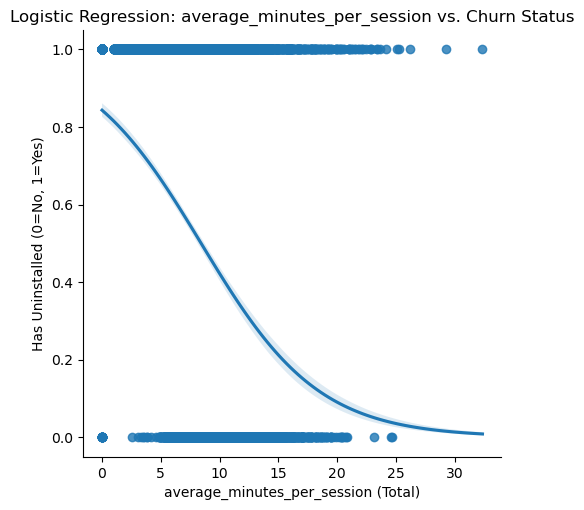

In [80]:
def plot_feature_relationships(df, feature_list):
    """
    Plots logistic regression plots for each specified feature against churn status.

    Parameters:
        df (DataFrame): DataFrame containing user features and churn status.
        feature_list (list): List of feature names to plot against churn status.
    """
    for feature in feature_list:
        sns.lmplot(x=feature, y='has_uninstalled', data=df,
                   logistic=True, palette='Set1', aspect=1)
        plt.xlabel(f"{feature} (Total)", fontsize=10)
        plt.ylabel("Has Uninstalled (0=No, 1=Yes)", fontsize=10)
        plt.title(f"Logistic Regression: {feature} vs. Churn Status")
        plt.show()

# features to plot
features_to_plot = ['messages_sent_count', 'messages_received_count',
                    'total_minutes_played', 'average_minutes_per_session']

plot_feature_relationships(user_features_train, features_to_plot)

#### Correlation Analysis:
Insight from correlation analysis and Logistic regression plots:

- There are moderate negative correlations between has_uninstalled and the activity features (messages_sent_count, messages_received_count, total_minutes_played, and average_minutes_per_session). This suggests that higher engagement in these activities might be associated with a lower likelihood of removing the app.
- Messages Sent and Received: Users who have uninstalled the app generally sent and received fewer messages compared to those who kept the app. This indicates lower engagement in messaging activities among churned users.
- Music Listening Habits: Similarly, the total minutes of music played and the average session duration are lower for users who removed the app. This implies that less engagement with the music feature might be a an indicator of potential churn.
- These findings suggest that churn is likely related to lower overall engagement across the app's features. Users who are more active in sending/receiving messages and listening to music are less likely to uninstall the app.

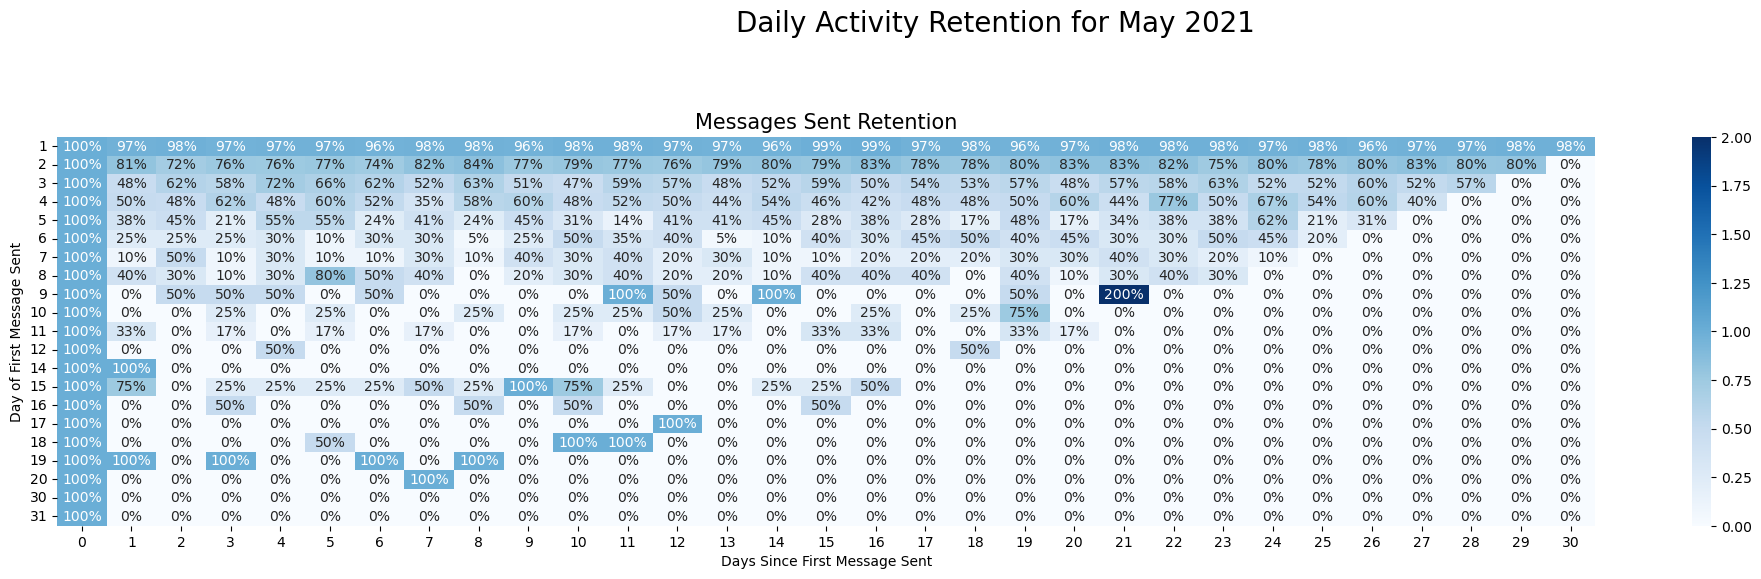

In [68]:
#  Cohort Analysis for daily messages sent
first_message_day = message_sent_train.groupby('id')['Day'].min().reset_index()
first_message_day.columns = ['id', 'FirstMessageDay']
message_sent_train = message_sent_train.merge(first_message_day, on='id')

# Create the retention matrix for users who sent a message
# This will show , for each day in May, the percentage of users who sent a message again on subsequent days.
sent_message_retention = pd.crosstab(message_sent_train['FirstMessageDay'], message_sent_train['Day'] - message_sent_train['FirstMessageDay'])
sent_message_retention = sent_message_retention.divide(sent_message_retention.iloc[:, 0], axis=0)
plt.figure(figsize=(20, 15))
plt.suptitle('Daily Activity Retention for May 2021', fontsize=20)
plt.subplot(3, 1, 1)
sns.heatmap(sent_message_retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Messages Sent Retention', fontsize=15)
plt.xlabel('Days Since First Message Sent')
plt.ylabel('Day of First Message Sent')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

#### Cohort Analysis:
The cohort analysis above looks at users who have sent a message for the first time in this month and how many sent messages on subsequent days of that month.

- Certain days may show increased retention. Users who first sent messages on the first day of May remained highly engaged with the app with about 96-99% users from this cohort sending messages everyday. This might suggest specific events or marketing efforts could have influenced user engagement from this cohort. 
- There's an opportunity for makreting efforts to engage the other cohorts, such as those users who first sent messages on the 11th day of the month who displayed drop-off rate over the month.

In [100]:
def calculate_predictive_power(df, target):
    """
    Calculates the predictive power score (PPS) for variables in a dataframe against a target variable.
    
    """
    # Target variable should be of type string for PPS calculation
    df[target] = df[target].astype(str)
    predictors_df = pps.predictors(df, target)
    sorted_predictors = predictors_df.sort_values(by="ppscore", ascending=False)
    
    return sorted_predictors

predictors_df = calculate_predictive_power(user_features_train, "has_uninstalled")
predictors_df

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,messages_sent_count,has_uninstalled,0.850894,classification,True,weighted F1,0.502,0.925745,DecisionTreeClassifier()
1,segment,has_uninstalled,0.820616,classification,True,weighted F1,0.502,0.910667,DecisionTreeClassifier()
2,messages_received_count,has_uninstalled,0.731637,classification,True,weighted F1,0.502,0.866355,DecisionTreeClassifier()
3,total_minutes_played,has_uninstalled,0.473210,classification,True,weighted F1,0.502,0.737659,DecisionTreeClassifier()
4,average_minutes_per_session,has_uninstalled,0.428127,classification,True,weighted F1,0.502,0.715207,DecisionTreeClassifier()
5,id,has_uninstalled,0.019549,classification,True,weighted F1,0.502,0.511735,DecisionTreeClassifier()


#### Predictive Power Analysis
Looking at another alternative of correlation analysis using predictive power score: The predictive power score is an finds more patterns in the data than correlation does
- Even though messages_sent_count and messages_received_count show quite a high ppscore in predicting a user's likelihood to uninstall the app, the other features also show quite a notable ppscore indicating that these can be used to predict a user who will uninstall the app.

## 1.3.2 Segmentation
Devise a way to segment the users into groups so that the Marketing department can develop
targeted actions for specific groups. Add a column to have uninstalled test.csv with the result of
the segmentation.


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


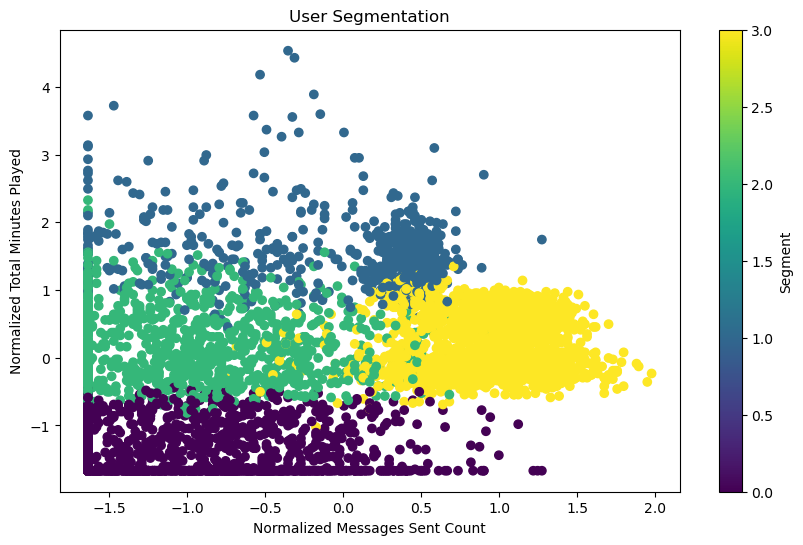

In [103]:
def segment_users(user_features_train, user_features_test, features_to_normalize, n_clusters=4, random_state=42):
    """
    Function to normalize features, fit a KMeans model, and segment both train and test user data.

    Parameters:
    - user_features_train: DataFrame with training data.
    - user_features_test: DataFrame with test data.
    - features_to_normalize: list of feature names to normalize.
    - n_clusters: number of clusters for KMeans.
    - random_state: random state for KMeans.

    Returns:
    - user_features_train with 'segment' column added.
    - user_features_test with 'segment' column added.
    - kmeans model that was fitted on the training data.
    """
    
    user_features_normalized_train = user_features_train[features_to_normalize].copy()
    user_features_normalized_test = user_features_test[features_to_normalize].copy()
    
    # Normalize the training data before fitting kmeans clustering
    scaler = StandardScaler()
    scaler.fit(user_features_normalized_train)
    user_features_normalized_train = scaler.transform(user_features_normalized_train)
    
    # Fit the KMeans model on the normalized training data
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    train_segments = kmeans.fit_predict(user_features_normalized_train)
    
    # Add segment data to the training data
    user_features_train['segment'] = train_segments
    
    # Normalize the test data using the scaler fitted on the training data
    user_features_normalized_test = scaler.transform(user_features_normalized_test)
    
    # Predict segments for the normalized test data using the fitted KMeans model
    test_segments = kmeans.predict(user_features_normalized_test)
    
    # Add segment data to the test data
    user_features_test['segment'] = test_segments
    
    # Visualize the segments 
    plt.figure(figsize=(10, 6))
    plt.scatter(user_features_normalized_train[:, 0], user_features_normalized_train[:, 2], c=train_segments)
    plt.title('User Segmentation')
    plt.xlabel('Normalized Messages Sent Count')
    plt.ylabel('Normalized Total Minutes Played')
    plt.colorbar(label='Segment')
    plt.show()
    
    return user_features_train, user_features_test, kmeans

features_to_normalize = ['messages_sent_count', 'messages_received_count', 'total_minutes_played', 'average_minutes_per_session']
user_features_train_segmented, user_features_test_segmented, kmeans_model = segment_users(user_features_train, user_features_test, features_to_normalize)

In [111]:
def aggregate_user_segments(df):
    """
    Aggregates user features by segment.

    """
    segments = df.groupby('segment').agg({
        'messages_sent_count': ('mean'), 
        'messages_received_count': ('mean'), 
        'total_minutes_played': ('mean'), 
        'average_minutes_per_session': ('mean'), 
        'id': 'nunique'
    })

    return segments

aggregate_user_segments(user_features_train)

,messages_sent_count,messages_received_count,total_minutes_played,average_minutes_per_session,id
segment,,,,,
0,55.832930,84.276029,14.615012,1.723255,1239
1,113.435055,137.449139,154.946792,15.567512,639
2,51.728512,77.503145,89.461216,9.192202,954
3,185.333948,178.340406,91.509225,9.400113,2168


#### Segmentation Analysis

- Segment 0: This group has the lowest average messages sent and received, and they also spend the least amount of time playing music.

- Segment 1: Users in this segment are high on both messages sent and received and have the highest total minutes played. They also have the longest average minutes per session. This segment could be considered the 'power users' of the app. They are highly engaged, and despite being a smaller group, they are likely driving a significant portion of the activity on the app.

- Segment 2: This group has moderate activity in terms of messages sent and received and time spent playing music. Their average minutes per session are the lowest, which could indicate these users are more casual in their app usage, perhaps using it more for communication than for music.

- Segment 3: These users send the most messages and receive a high number of messages but do not spend as much time playing music compared to Segment 1. Their average session time is quite brief, which suggests they are highly engaged in communication but may not use the app as much for music listening.

#### Marketing Implications:

- For Segment 0, the focus could be on increasing engagement through personalized push notifications or by introducing new features to encourage more frequent use. This data would also need to be enriched further by exploring other things that could give more insights about user behaviour such as analysing the type of content users engage with and tailor the marketing efforts based on that.
- Segment 1 users could be targeted with loyalty programs or exclusive content given their high engagement.
- Segment 2 might benefit from features that make the app more engaging for casual use, possibly through gamification or social features.
- Segment 3 may appreciate features that enhance the messaging experience since that is where their primary activity lies.

### 1.3.3 Modelling

In [115]:
def set_features_and_target(df):
    '''
    Returns two data frames with features and target variables.
            Parameters:
                    df (str): Pandas dataframe
    '''
    X = df.drop(['id','has_uninstalled','segment'], axis=1)
    y = df['has_uninstalled']
    
    return X,y
                 
X,y = set_features_and_target(user_features_train)
print(X.shape, y.shape)

(5000, 4) (5000,)


In [119]:
def train_test_split_df(X,y):
    '''
    Creates train and test split.

    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_df(X,y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3500, 4) (3500,)
(1500, 4) (1500,)


In [120]:
def model_application(X_train,y_train,optimiser):
    # Building model
    '''
    Model application. If optimiser is true , a grid search is applied to optimise the model. 
    If optimiser is false base model is used
            Parameters:
                    X_train : Pandas dataframe of feature set training variables
                    y_train : Pandas dataframe of predictor variable for training set.
                    optimiser : Boolean to indicate optimisation required. 
            Returns:
                    Random Forest model.
    '''
    if optimiser == True:
                # Build the model with K-fold validation and GridSearch to find the best parameters

                # Defining all the parameters
                params = {
                'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10],
                'min_samples_leaf': [1, 3, 10],
                'criterion': ["entropy", "gini"]
                }

                cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=15)

                # Building model
                rf = RandomForestClassifier()

                # Parameter estimating using GridSearch
                grid = GridSearchCV(rf, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)
                
                # Fitting the model
                grid.fit(X_train, y_train)

                dtc_grid_val_score = grid.best_score_
                print('Best Score:', dtc_grid_val_score)
                print('Best Params:', grid.best_params_)
                print('Best Estimator:', grid.best_estimator_)

                rf_clf = grid.best_estimator_
    else:
                rf_clf = RandomForestClassifier(n_estimators=150,
                                                max_depth=16,
                                                criterion='gini',
                                                class_weight='balanced',
                                                min_samples_split=10,
                                                max_leaf_nodes=20,
                                                max_features=0.5,
                                                bootstrap=True)
                rf_clf.fit(X_train, y_train)

    return rf_clf

optimiser = False
rf_clf = model_application(X_train,y_train,optimiser)

In [121]:
def model_predict(X_test):
    '''
    Create y_pred , model prediction based on test set features.
            Parameters:
                    X_test (str): Pandas dataframe
            Returns:
                    y_pred
    '''
    y_pred = rf_clf.predict(X_test)
    
    return y_pred

y_pred = model_predict(X_test)
print('Training Accuracy Score(%):',rf_clf.score(X_train,y_train)*100)
print('Test Accuracy Score(%):',rf_clf.score(X_test,y_test)*100)

Training Accuracy Score(%): 96.62857142857143
Test Accuracy Score(%): 96.13333333333334


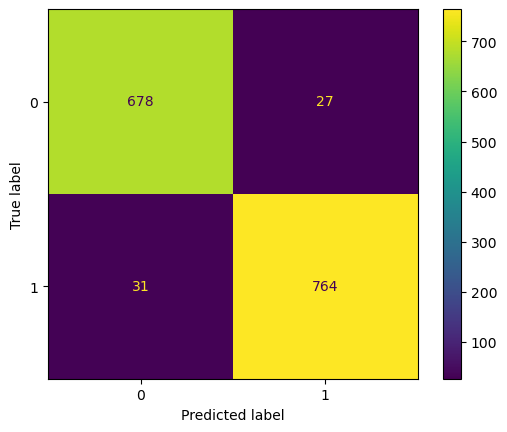

array([[678,  27],
       [ 31, 764]], dtype=int64)

In [122]:
def generate_confusion_matrix(y_test, y_pred):
    '''
    Generates confusion matrix.
            Parameters:
                    y_test (array): numpy array of actual values
                    y_pred (array): numpy array of predicted values
            Returns:
                    Y_pred
    '''
    
    cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
    disp.plot()
    plt.grid(False) 
    plt.show()
    
    return cm

generate_confusion_matrix(y_test, y_pred)

In [123]:
def generate_perfomance_metrics(y_test,y_pred):
    '''
    Generates perfomance metrics precision, recall, f1 score, accuracy
            Parameters:
                    y_test (array): numpy array of actual values
                    y_pred (array): numpy array of predicted values
            Returns:
                    y_pred
    '''
    rf_model_score = accuracy_score(y_test, y_pred)
    print('Model Accuracy:', rf_model_score)
    return print('Classification Report:\n', classification_report(y_test, y_pred))

generate_perfomance_metrics(y_test,y_pred)

Model Accuracy: 0.9613333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       705
           1       0.97      0.96      0.96       795

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



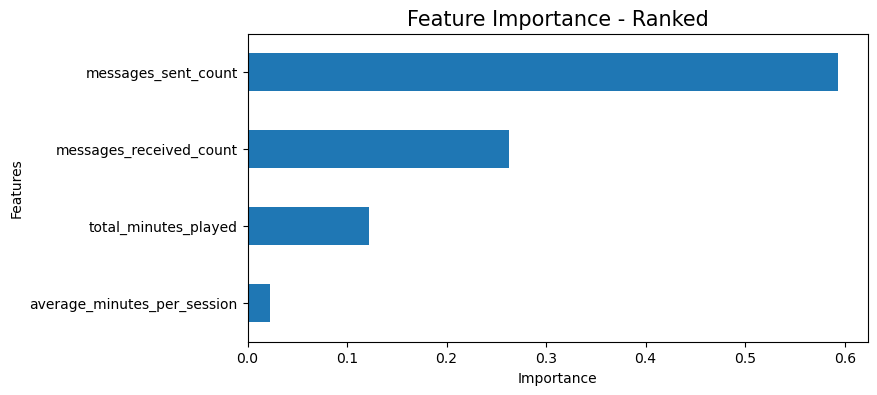

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


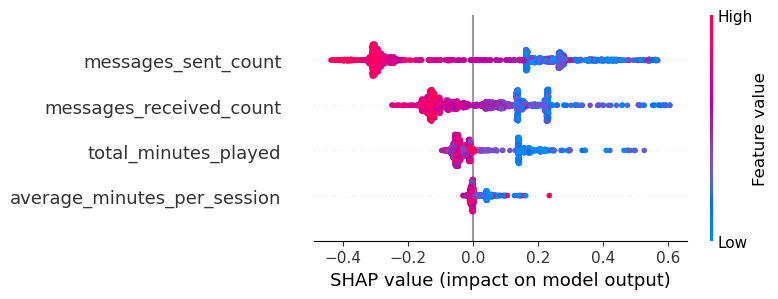

In [127]:
def generate_shapley_plots(model, X, class_index=1):
    """
    Generate SHAP summary plots for model interpretability.

    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values[class_index], X, show=False)

    plt.show()

generate_shapley_plots(rf_clf, X_test)

### Insights from modelling:

- Precision for class 1 (Churn): The model has a precision of 0.97 for predicting churn. This means that when the model predicts that a user will uninstall the app, it is correct 97% of the time.

- Recall for class 1 (Churn): The recall for churn is 0.96, indicating that out of all the users who actually uninstalled the app, the model correctly identifies 96% of them.

- F1-score for class 1 (Churn): With an F1-score of 0.96 for churn, the model's precision and recall are very well balanced, which is excellent for predictive performance.

- Precision for class 0 (No Churn): The model's precision for predicting no churn is also high at 0.96, meaning that when the model predicts a user will keep the app, it is correct 96% of the time.

- Recall for class 0 (No Churn): The model has a recall of 0.96 for no churn, which means it correctly identifies 96% of the users who did not uninstall the app.

- F1-score for class 0 (No Churn): The F1-score of 0.96 for no churn suggests a strong balance between precision and recall for this class as well.

Overall, the model is effective at predicting both users who will uninstall the app and those who will keep it. The balance between precision and recall across both classes indicates that the model is not only accurate overall but also fair and does not favor one class over the other.

### Model intepretability 

The Feature Importance plot indicates the relative importance of different features used by the model to predict churn.

- messages_sent_count and messages_received_count appears to be the most important features, implying that the number of messages sent and recived by a user is a strong predictor of whether they will uninstall the app.

##### SHAP Value Plot:
The SHAP summary plot shows the impact of each feature on the model's output. The SHAP value represents the direction and magnitude of a feature's effect on the model prediction. A positive SHAP value pushes the prediction towards a positive outcome (churn), and a negative value towards a negative outcome (no churn).

- High values of messages_sent_count tend to have a high positive impact on the model's prediction for churn. In contrast, lower values of this feature have a variety of impacts, suggesting that users with fewer sent messages might churn.

- total_minutes_played shows a concentration of negative SHAP values for higher feature values, implying that users who spend more time in the app listening to music are less likely to churn.

The model indicates that the amount of interaction a user has with the app, measured by messages sent and received, is the most predictive of churn. Users who are more active in terms of messaging are less likely to uninstall the app. The overall engagement, measured by the total minutes music played, also contributes to the prediction but to a lesser extent.

In [145]:
# Apply the trained model to the test set and add the churn prediction column for each user in the test set
X_test_features = user_features_test[['messages_sent_count', 'messages_received_count', 
                                      'total_minutes_played', 'average_minutes_per_session']]
# apply trained model
predicted_churn = rf_clf.predict(X_test_features)
predictions_df = user_features_test[['id','segment']].copy()  
predictions_df['has_uninstalled'] = predicted_churn
# save the test predictions as csv file with id, segment and has_uninstalled columns
predictions_df.to_csv('has_uninstalled_test_updated.csv',index=False)
predictions_df.head()

,id,segment,has_uninstalled
0,5000,3,0
1,5001,2,1
2,5002,2,1
3,5003,3,0
4,5004,1,0


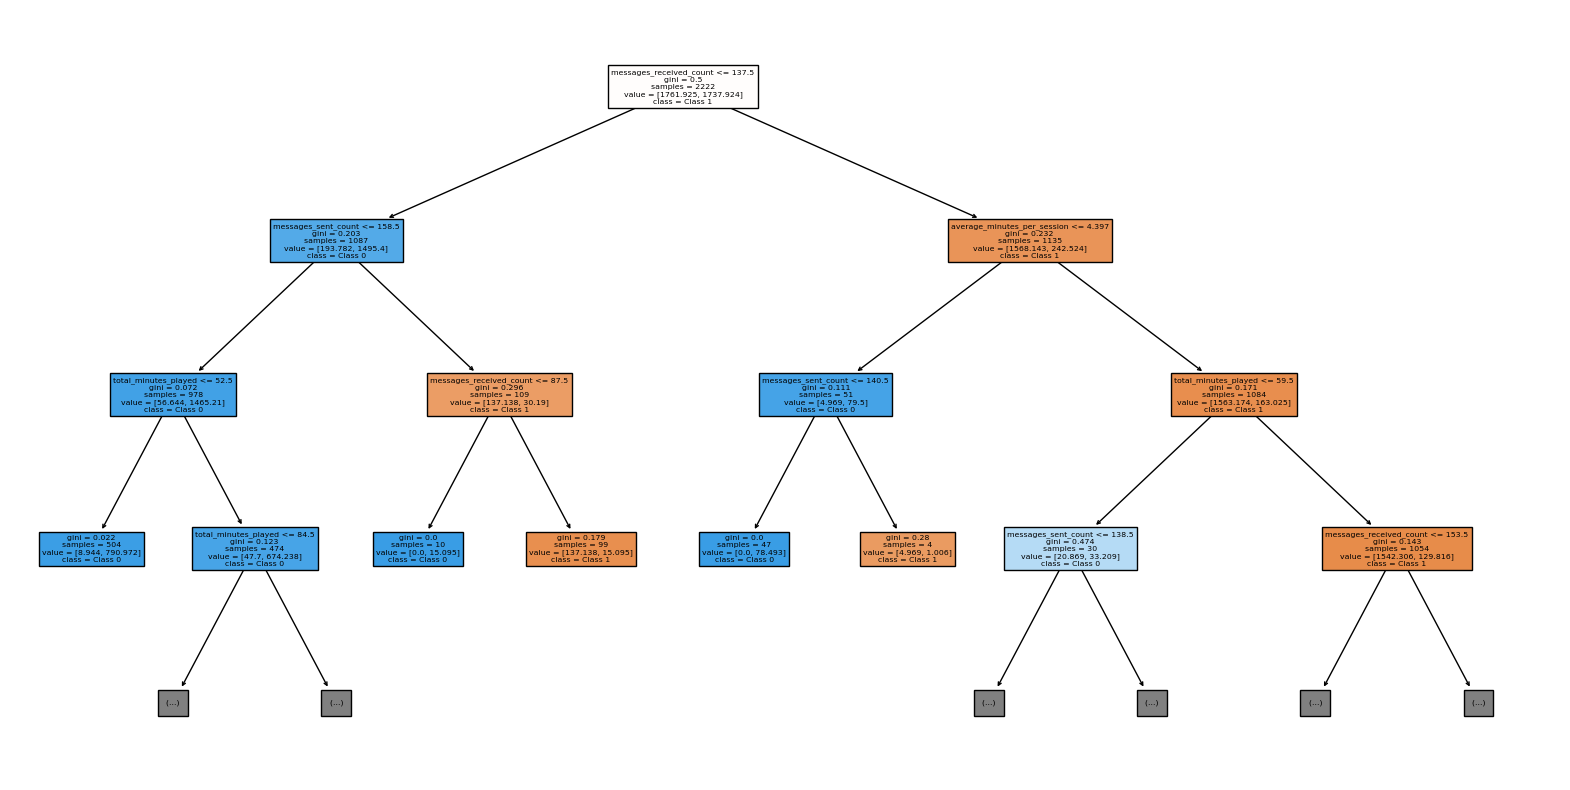

In [144]:
## Random Snapshot of one of the trees from the fitted random forest
chosen_tree = rf_clf.estimators_[0]
plt.figure(figsize=(20,10))
tree.plot_tree(chosen_tree, feature_names=X_train.columns, class_names=['Class 1', 'Class 0'], filled=True, max_depth=3)
plt.show()

####  ----------------------------------------------------------------------------   END !!! ----------------------------------------------------------------------------------------------